# Chapter 7. 텍스트 문서의 범주화 - (1) 텍스트 임베딩


### 핸즈온 안내

- Chapter07 텍스트 문서의 범주화 핸즈온에 필요한 패키지 및 데이터
    - PyPi
        - keras (2.2.4)
        - tensorflow (1.13.1)
        - gensim (3.7.1)
        - bs4 (0.0.1)
        - 그 외 나머지 패키지들은 아나콘다 기본 PyPi 패키지 사용 가능
    - 데이터
        - Chapter07 디렉토리에 data 폴더 생성 후 다음 데이터들을 다운로드 받아 압축해제
        - IMDB 영화 리뷰 데이터셋 : http://ai.stanford.edu/~amaas/data/sentiment/
        - 아마존 영화 리뷰 데이터셋 : https://www.kaggle.com/bittlingmayer/amazonreviews
        - pre-train GloVe 모델 : http://nlp.stanford.edu/data/glove.6B.zip

### 텍스트 분류의 예시
- 스팸 메일 필터링
- 감성 분류
- 장르 분류
- 보험금 청구서 사기 탐지 등

### 전통적인 텍스트 범주화
- 문장 나누기
- 토큰화(Tokenization)
- 어간 추출 (Stemming)
    - ('재생해', '재생하고', '재생했다') -> 기본형 '재생하다'
- 원형 복원 (Lemmatization)
    - 'better' -> 원형 'good' (사전에 정의됨)
- 텍스트 정리 : 대소문자 변환, 오타 수정, 불용어 제거 등

### BoW (Bag of Words)
- 텍스트 문서에서 특징을 추출하고 텍스트의 벡터 표현을 생성하는, 가장 간단하면서도 강력한 기술 중 하나
- 순서 없이 각 단어의 빈도를 기반으로 생성한 희소한(sparse) 벡터

### TF-IDF (Term Frequency – Inverse Document Frequency)
- TF-IDF 값은 어떤 단어가 특정 문서에 나타나는 횟수에 비례하여 늘어나고, 그 단어가 전체 문서에서 두루 나타나는 빈도수에 비례하여 작아진다
- TF-IDF = TF x IDF
    - TF : 문서 내 단어가 등장한 빈도
    - IDF : 단어가 다른 문서에 자주 등장한 빈도의 역수

In [1]:
import os
import nltk
# import logging
import pandas as pd
import numpy as np

----
## IMDB dataset

- IMDB 영화 리뷰 데이터를 다운로드 받아 data 디렉토리에 압축 해제한다
    - 다운로드 : http://ai.stanford.edu/~amaas/data/sentiment/
    - 저장경로 : data/aclImdb
- IMDB 영화 리뷰 데이터 세트
    - 바이너리로 감성을 분류하기 위한 데이터 세트다. 훈련을 위한 25,000개 영화 리뷰 데이터와 테스트를 위한 25,000개 영화 리뷰 데이터가 포함돼 있다. 또한 레이블이 지정되지 않은 추가 데이터도 있다. (10만건, 510MB)
- 로드 함수는 dataloader/loader.py 참조

In [2]:
from dataloader.loader import Loader

In [3]:
# train, test, unsup 데이터 로드하기
# data/aclImdb 경로에 저장한 IMDB 영화 리뷰 데이터를 로드한다

train_df = Loader.load_imdb_data('train')
print(f'train_df.shape : {train_df.shape}')

test_df = Loader.load_imdb_data('test')
print(f'test_df.shape : {test_df.shape}')

unsupervised = Loader.load_imdb_unsup()
print(f'unsupervised.shape : {unsupervised.shape}')

train_df.shape : (25000, 2)
test_df.shape : (25000, 2)
unsupervised.shape : (50000, 1)


In [4]:
train_df.head()

,review,sentiment
416,"This movie is very entertaining, and any criti...",1
23938,"This is the worst movie I have seen since ""I K...",0
2753,THIS POST MAY CONTAIN SPOILERS :Although it wa...,1
14539,"After having seen and loved Postal (yes, I act...",0
8152,"Drum scene is wild! Cook, Jr. is unsung hero o...",1


In [5]:
# 로드한 train, test, unsupervised 텍스트 데이터를 하나로 묶기
corpus = unsupervised['review'].tolist() + train_df['review'].tolist() + test_df['review'].tolist()
print(f'corpus size : {len(corpus)}')

corpus size : 100000


----
## tokenize

- 각 문장을 단어들의 리스트로 tokenize한다

In [6]:
# tokenize sentences in corpus
# nltk.word_tokenize와 달리, 단어 속 특수기호도 모두 split한다

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document.lower()) for document in corpus]

print(f'tokenized_corpus size : {len(tokenized_corpus)}')
print(f'tokenized_corpus[0] : \n', tokenized_corpus[0])

tokenized_corpus size : 100000
tokenized_corpus[0] : 
 ['this', 'film', 'is', 'about', 'two', 'brothers', 'executing', 'the', 'ultimate', 'scheme', 'to', 'con', 'a', 'rich', 'attractive', 'woman', '.', 'i', 'never', 'thought', 'a', 'rachel', 'weisz', 'movie', 'could', 'be', 'dull', 'and', 'senseless', 'as', 'this', ',', 'but', '"', 'the', 'brothers', 'bloom', '"', 'really', 'takes', 'that', 'trophy', '.', 'the', 'plot', 'is', 'dull', ',', 'and', 'it', 'fails', 'to', 'engage', 'me', 'at', 'all', '.', 'the', 'pacing', 'is', 'so', 'slow', ',', 'that', 'i', 'felt', 'so', 'bored', 'after', 'the', 'first', 'twenty', 'minutes', '.', 'they', 'could', 'have', 'at', 'least', 'cut', 'fifteen', 'minutes', 'of', 'that', 'and', 'not', 'affected', 'the', 'story', '.', 'it', "'", 's', 'just', 'far', 'too', 'long', ',', 'with', 'so', 'many', 'uninteresting', 'and', 'unimportant', 'scenes', 'in', 'between', 'the', 'useful', 'scenes', '.', 'i', 'feel', 'so', 'sorry', 'for', 'rinko', 'kikuchi', "'", 's', 

----
## Word2Vec

- 예측을 통한 심층 학습 기반 모델로서  밀집, 고품질, 분산성, 연속성을 가진 단어 표현 벡터를 생성한다. 
- 단어 표현 벡터는 문맥과 의미의 유사성을 표현한다
- 단어 임베딩 표현을 만들기 위해 두 가지 아키텍처
    - CBOW (Continuous Bag of Words)
    - Skip-gram
- 본 핸즈온에선 gensim word2vec을 사용하며, gensim은 다음 명령어로 설치할 수 있다.
```
pip install gensim
```


![word2vec](assets/handson01_word2vec.png)

In [7]:
from gensim.models import word2vec

In [8]:
# word2vec 모델 학습시키기

# word2vec 학습 과정 로그찍기
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# word2vec 모델 학습
# 도서의 소스코드대로(iter=1000) 실행시키면 5~6시간 이상 소요되므로 주의바랍니다.
w2v_model = word2vec.Word2Vec(tokenized_corpus, 
                              size=50,      # Word vector dimensionality
                              window=10,    # Context window size
                              min_count=5,  # Minimum word count
                              sample=1e-3,  # Downsample setting for frequent words 
                              iter=30       # Number of iterations (epochs) over the corpus
                             )

# 학습된 모델 저장
w2v_model.save('w2v_imdb.model')

In [9]:
# 위에서 학습하여 파일로 저장한 word2vec 모델을 로드
w2v_model = word2vec.Word2Vec.load('w2v_imdb.model')
print(f'vocab size : {len(w2v_model.wv.vocab)}')
print(f'vector size : {w2v_model.wv.vector_size}')

vocab size : 54660
vector size : 50


----
## Word2Vec 유사단어 구하기

In [10]:
w2v_model.wv.most_similar(['superior'])

[('inferior', 0.7878676056861877),
 ('truer', 0.6605010628700256),
 ('surpasses', 0.6460198760032654),
 ('maligned', 0.64519864320755),
 ('comparable', 0.6392448544502258),
 ('weaker', 0.6164555549621582),
 ('lauded', 0.6141617298126221),
 ('sotl', 0.6120660305023193),
 ('friendlier', 0.605718195438385),
 ('exceeds', 0.6009249091148376)]

In [11]:
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                 for search_term in ['good','superior','violent', 'romantic', 'nasty', 'unfortunate', 
                                      'predictable', 'hilarious', 'fascinating', 'boring','confused', 'sensitive',
                                     'imaginative','senseless', 'bland','disappointing']}
pd.DataFrame(similar_words).transpose()

,0,1,2,3,4
good,decent,bad,great,nice,cool
superior,inferior,truer,surpasses,maligned,comparable
violent,brutal,gruesome,sadistic,graphic,violence
romantic,romance,screwball,bittersweet,frothy,sentimental
nasty,sadistic,gory,sleazy,icky,demented
unfortunate,disastrous,unacceptable,unlucky,inadequate,unknown
predictable,clichéd,implausible,contrived,dull,formulaic
hilarious,hysterical,funny,priceless,hillarious,comical
fascinating,compelling,enthralling,captivating,truthful,unique
boring,dull,tedious,pointless,predictable,uninteresting


----
## 시각화

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

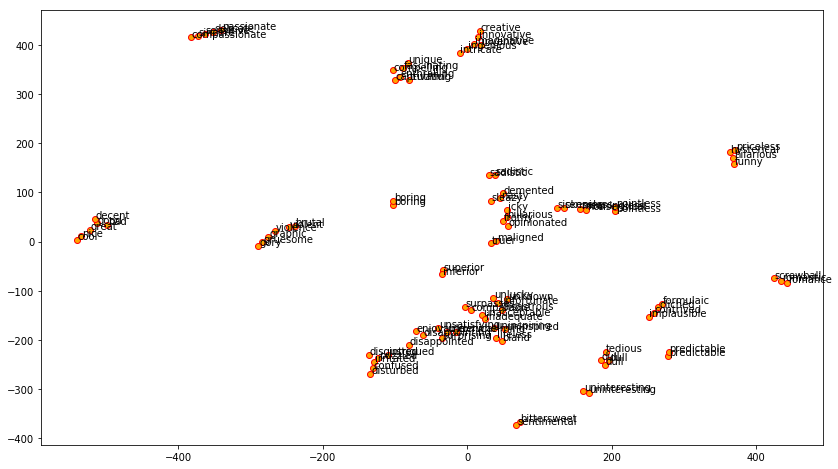

In [13]:
pd.options.display.max_colwidth = 200
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

----
## GloVe

- pre-train된 GloVe 임베딩 벡터를 다운로드 받아 data 디렉토리에 압축 해제한다
    - 다운로드 : http://nlp.stanford.edu/data/glove.6B.zip
    - 저장경로 : data/glove.6B
- 글로벌 벡터(Global Vectors)의 약자로, 밀집 단어 벡터를 얻기 위해 사용하는 word2vec과 유사한 비지도 학습모델
- 학습 과정에서 전역적인 단어-문맥 동시출현행렬을 사용
- Word2Vec과의 비교
    - Word2vec은 단어 동시 발생 쌍 각각의 국소적이고 개별적인 예제로부터 시작
    - GloVe는 코퍼스에 있는 모든 단어의 동시 발생 통계를 전역에서 결합해서 시작한다
- 본 핸즈온에서 구현된 코드는 dataloader/embeddings.py 를 참조


In [14]:
from dataloader.embeddings import GloVe

In [15]:
# glove.6B.50d pre-trained 벡터 로드
glove = GloVe(50)
initial_embeddings = glove.get_embedding({'good':2, 'movie':3, 'computer':4, 'coffee':5})

Reading 50 dim GloVe vectors
Found 400000 word vectors.
words not found in embeddings: 0


In [18]:
# 로드한 임베딩 벡터의 단어 수가 입력 vocab보다 2개 많은 이유는
# 0번째는 공백 단어를 위한 벡터로, zero 벡터이다
# 1번째는 OOV(Out-Of-Vocabulary)를 위한 벡터로, 나머지 벡터들의 평균이다
# GloVe에서 찾지 못한 단어들의 벡터값은 이 OOV용 평균벡터에 약간의 노이즈를 더해 사용한다
initial_embeddings.shape

(6, 50)

In [19]:
initial_embeddings[2]

array([-0.35585999,  0.52130002, -0.61070001, -0.30131   ,  0.94862002,
       -0.31538999, -0.59830999,  0.12188   , -0.031943  ,  0.55694997,
       -0.10621   ,  0.63398999, -0.4734    , -0.075895  ,  0.38247001,
        0.081569  ,  0.82213998,  0.22220001, -0.0083764 , -0.76620001,
       -0.56252998,  0.61759001,  0.20292   , -0.048598  ,  0.87814999,
       -1.65489995, -0.77418   ,  0.15435   ,  0.94823003, -0.39520001,
        3.73020005,  0.82854998, -0.14104   ,  0.016395  ,  0.21115001,
       -0.036085  , -0.15587001,  0.86583   ,  0.26309001, -0.71015   ,
       -0.03677   ,  0.0018282 , -0.17704   ,  0.27032   ,  0.11026   ,
        0.14133   , -0.057322  ,  0.27206999,  0.31305   ,  0.92771   ])